# AUPIMO

Advance use cases of the metric AUPIMO (pronounced "a-u-pee-mo").

> For basic usage, please check the notebook [701a_aupimo.ipynb](./701a_aupimo.ipynb).

Includes:
- visualization of the PIMO curve
- theoretical AUPIMO of a random classifier ("baseline")
- understanding the x-axis (FPR) bounds
- customizing the x-axis (FPR) bounds


# What is AUPIMO?

The `Area Under the Per-Image Overlap [curve]` (AUPIMO) is a metric of recall (higher is better) designed for visual anomaly detection.

Inspired by the [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and [PRO](https://link.springer.com/article/10.1007/s11263-020-01400-4) curves, 

> AUPIMO is the area under a curve of True Positive Rate (TPR or _recall_) as a function of False Positive Rate (FPR) restricted to a fixed range. 

But:
- the TPR (Y-axis) is *per-image* (1 image = 1 curve/score);
- the FPR (X-axis) considers the (average of) **normal** images only; 
- the FPR (X-axis) is in log scale and its range is [1e-5, 1e-4]\* (harder detection task!).

\* The score (the area under the curve) is normalized to be in [0, 1].

AUPIMO can be interpreted as

> average segmentation recall in an image given that the model (nearly) does not yield false positives in normal images.

References in the last cell.

![AUROC vs. AUPRO vs. AUPIMO](./roc_pro_pimo.svg)

# Setup

Install `anomalib` using `pip`.

In [ ]:
# TODO(jpcbertoldo): replace by `pip install anomalib` when AUPIMO is released  # noqa: TD003
%pip install ../..

Change the directory to have access to the datasets.

In [2]:
from pathlib import Path

# NOTE: Provide the path to the dataset root directory.
#   If the datasets is not downloaded, it will be downloaded
#   to this directory.
dataset_root = Path.cwd().parent.parent / "datasets" / "MVTec"

Imports

In [ ]:
import cv2
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.ticker import FixedLocator, PercentFormatter
from numpy import ndarray
from scipy import stats
from torch import Tensor

from anomalib import TaskType
from anomalib.data import MVTec
from anomalib.data.utils import read_image
from anomalib.engine import Engine
from anomalib.metrics import AUPIMO, PIMO
from anomalib.models import Padim

In [4]:
%matplotlib inline

# Basics

This part was covered in the notebook [701a_aupimo.ipynb](./701a_aupimo.ipynb), so we'll not discuss it here.

It will train a model and evaluate it using AUPIMO.
We will use dataset Leather from MVTec AD with `PaDiM` (performance is not the best, but it is fast to train).

> See the notebooks below for more details on:
> - datamodules: [100_datamodules](https://github.com/openvinotoolkit/anomalib/tree/main/notebooks/100_datamodules);
> - models: [200_models](https://github.com/openvinotoolkit/anomalib/tree/main/notebooks/200_models).

In [ ]:
# train the model
task = TaskType.SEGMENTATION
datamodule = MVTec(
    root=dataset_root,
    category="leather",
    image_size=256,
    train_batch_size=32,
    eval_batch_size=32,
    num_workers=8,
    task=task,
)
model = Padim(
    # only use one layer to speed it up
    layers=["layer1"],
    n_features=64,
    backbone="resnet18",
    pre_trained=True,
)
engine = Engine(
    pixel_metrics="AUPIMO",  # others can be added
    accelerator="auto",  # \<"cpu", "gpu", "tpu", "ipu", "hpu", "auto">,
    devices=1,
    logger=False,
)
engine.fit(datamodule=datamodule, model=model)
# infer
predictions = engine.predict(dataloaders=datamodule.test_dataloader(), model=model, return_predictions=True)

Compute AUPIMO

In [6]:
aupimo = AUPIMO(
    # with `False` all the values are returned in a dataclass
    return_average=False,
)

anomaly_maps = []
masks = []
labels = []
image_paths = []
for batch in predictions:
    anomaly_maps.append(batch_anomaly_maps := batch["anomaly_maps"].squeeze(dim=1))
    masks.append(batch_masks := batch["mask"])
    labels.append(batch["label"])
    image_paths.append(batch["image_path"])
    aupimo.update(anomaly_maps=batch_anomaly_maps, masks=batch_masks)

# list[list[str]] -> list[str]
image_paths = [item for sublist in image_paths for item in sublist]
anomaly_maps = torch.cat(anomaly_maps, dim=0)
masks = torch.cat(masks, dim=0)
labels = torch.cat(labels, dim=0)

# `pimo_result` has the PIMO curves of each image
# `aupimo_result` has the AUPIMO values
#     i.e. their Area Under the Curve (AUC)
pimo_result, aupimo_result = aupimo.compute()

Metric `AUPIMO` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.


Statistics and score distribution.

MEAN
aupimo_result.aupimos[labels == 1].mean().item()=0.7428374946357311
OTHER STATISTICS
DescribeResult(nobs=92, minmax=(0.0, 1.0), mean=0.7428374946357313, variance=0.08757776807097678, skewness=-0.9284572154639179, kurtosis=-0.3300816832805764)


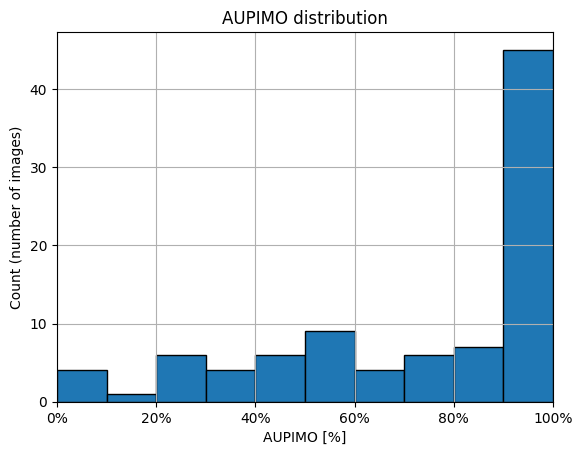

In [7]:
# the normal images have `nan` values because
# recall is not defined for them so we ignore them
print(f"MEAN\n{aupimo_result.aupimos[labels == 1].mean().item()=}")
print(f"OTHER STATISTICS\n{stats.describe(aupimo_result.aupimos[labels == 1])}")

fig, ax = plt.subplots()
ax.hist(aupimo_result.aupimos[labels == 1].numpy(), bins=np.linspace(0, 1, 11), edgecolor="black")
ax.set_ylabel("Count (number of images)")
ax.set_xlim(0, 1)
ax.set_xlabel("AUPIMO [%]")
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.grid()
ax.set_title("AUPIMO distribution")
fig  # noqa: B018, RUF100

Until here we just reproduded the notebook with the basic usage of AUPIMO.

# The PIMO curve 

We'll select a bunch of images to visualize the PIMO curves.

To make sure we have best and worst detection examples, we'll use the representative samples selected in the previous notebook ([701b_aupimo_advanced_i.ipynb](./701b_aupimo_advanced_i.ipynb)).

> Note the FPR (X-axis) is the average (in-image) FPR of the normal images in the test set. We'll note it as `FPRn`.

In [8]:
# representative samples (in terms of the AUPIMO value)
# from lowest to highest AUPIMO score
samples = [65, 7, 58, 63, 22]

In [9]:
def fmt_pow10(value: float) -> str:
    """Format the power of 10."""
    return "1" if value == 1 else f"$10^{{{int(np.log10(value))}}}$"


def plot_pimo_with_auc_zone(
    ax: Axes,
    tpr: ndarray,
    fpr: ndarray,
    lower_bound: float,
    upper_bound: float,
    fpr_in_auc: ndarray,
    tpr_in_auc: ndarray,
) -> None:
    """Helper function to plot the PIMO curve with the AUC zone."""
    # plot
    ax.plot(fpr, tpr, linewidth=3.5)
    ax.axvspan(lower_bound, upper_bound, color="magenta", alpha=0.3, zorder=-1)
    ax.fill_between(fpr_in_auc, tpr_in_auc, alpha=1, color="tab:purple", zorder=1)

    # config plots
    ax.set_ylabel("TPR [%]")
    ax.yaxis.set_major_locator(FixedLocator(np.linspace(0, 1, 6)))
    ax.yaxis.set_major_formatter(PercentFormatter(1, 0, symbol=""))
    ax.set_ylim(0, 1 + 3e-2)
    ax.set_xlabel("FPRn")
    ax.set_xscale("log")
    ax.xaxis.set_major_locator(FixedLocator(np.logspace(-6, 0, 7)))
    ax.xaxis.set_major_formatter(lambda x, _: fmt_pow10(x))
    ax.set_xlim(1e-6 / (eps := (1 + 3e-1)), 1 * eps)
    ax.grid()

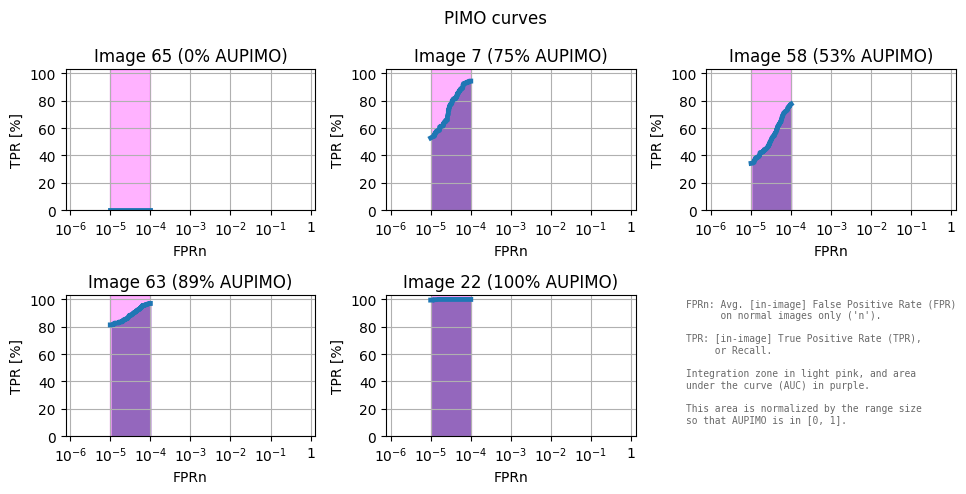

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5), layout="tight")

for ax, index in zip(axes.flatten(), samples, strict=False):
    score = aupimo_result.aupimos[index].item()
    tpr = pimo_result.per_image_tprs[index]
    fpr = pimo_result.shared_fpr
    lower_bound, upper_bound = aupimo.fpr_bounds
    threshs_auc_mask = (pimo_result.thresholds > aupimo_result.thresh_lower_bound) & (
        pimo_result.thresholds < aupimo_result.thresh_upper_bound
    )
    fpr_in_auc = fpr[threshs_auc_mask]
    tpr_in_auc = tpr[threshs_auc_mask]

    plot_pimo_with_auc_zone(ax, tpr, fpr, lower_bound, upper_bound, fpr_in_auc, tpr_in_auc)
    ax.set_title(f"Image {index} ({score:.0%} AUPIMO)")

axes[-1, -1].axis("off")
axes[-1, -1].text(
    -0.08,
    0,
    """
FPRn: Avg. [in-image] False Positive Rate (FPR)
      on normal images only ('n').

TPR: [in-image] True Positive Rate (TPR),
     or Recall.

Integration zone in light pink, and area
under the curve (AUC) in purple.

This area is normalized by the range size
so that AUPIMO is in [0, 1].
""",
    ha="left",
    va="bottom",
    fontsize="x-small",
    color="dimgray",
    font="monospace",
)

fig.suptitle("PIMO curves")
fig  # noqa: B018, RUF100

# Meaning of the FPRn bounds

AUPIMOo only uses _normal images_ in the X-axis -- i.e. the $\operatorname{FPRn}$.

**Why?** 

Because the integration range is a validation\* of "usable operating thresholds", so using $\operatorname{FPRn}$ makes it unbiased (to the anomalies).

> Recall that, in practice, a threshold is set to decide if a pixel/image is anomalous.
> 
> This strategy was inspired on [AUPRO](https://link.springer.com/article/10.1007/s11263-020-01400-4).

---

**Definition 1**: Average FPR on Normal Images ($\operatorname{FPRn}$):

$$
    \operatorname{FPRn} : t \mapsto \frac{1}{N} \sum_{i=1}^{N} \; \times \; \operatorname{FPR}^{i}(t)
$$

where $i$ and $N$ are, respectively, the index and the number of normal images in the test set. Note that $\operatorname{FPRn}$ is the empirical average of $\operatorname{FPR}^{i}$, so 

$$
    \operatorname{FPRn} \approx \mathbb{E} \left[ \operatorname{FPR}^{i} \right]
$$

**Defintion 2**: FPR of the $i$-th normal image ($\operatorname{FPR}^{i}$): 

$$
    \operatorname{FPR}^{i} : t \mapsto \frac{\text{Area of } \mathbb{a}^{i} \text{ above } t}{\text{Area of } \mathbb{a}^{i}}
$$

where $\mathbb{a}^{i}$ is the anomaly score map of the $i$-th image.

---

No further ado, let's visualize this $\operatorname{FPRn}$!

> For more details on this topic, check our paper in the last cell.

## Visualizing the FPR of normal images ($\operatorname{FPR}^{i}$)

$\operatorname{FPRn}$ is the average of $\operatorname{FPR}^{i}$, so let's first visualize the latter.

In [ ]:
# visalization of $FPR^i$
#   since normal images do not have anomalous pixels
#   their FPR actually correspond to the ratio of pixels
#   (wrongly) classified as anomalous

# we'll visualize 3 levels of FPR^(i) on some normal images
FRP_levels = [1e-2, 1e-3, 1e-4]
# technical detail: decreasing order of FPR --> increasing order of threshold


def threshold_from_fpr(anomaly_map: Tensor, fpr_level: float | Tensor) -> float:
    """Find the threshold that corresponds to the given FPR level.

    Args:
        anomaly_map (torch.Tensor): Anomaly map, assumed to be from a normal image.
        fpr_level (float): Desired FPR level.

    Returns:
        float: Threshold such that `(anomaly_map > threshold).mean() == fpr_level`.
    """
    # make a dicothomic search
    lower, upper = anomaly_map.min(), anomaly_map.max()  # initial bounds
    middle = (lower + upper) / 2
    fpr_level = torch.tensor(fpr_level)

    def fpr(threshold: Tensor) -> Tensor:
        return (anomaly_map > threshold).float().mean()

    while not torch.isclose(fpr(middle), fpr_level, rtol=1e-2):
        if torch.isclose(lower, upper, rtol=1e-3):
            break
        if fpr(middle) < fpr_level:
            upper = middle
        else:
            lower = middle
        middle = (lower + upper) / 2
    return middle.item()


fig, axes = plt.subplots(1, 3, figsize=(13, 5), layout="constrained")

# select normal images with low and high mean anomaly scores
avg_anom_score_per_image = anomaly_maps.mean(dim=(1, 2))
# get the indices of the normal images sorted by their mean anomaly score
argsort = avg_anom_score_per_image.sort().indices
argsort = argsort[torch.isin(argsort, torch.where(labels == 0)[0])]
# select first, median and last
normal_images_selection = argsort[[0, len(argsort) // 2, -1]]

# heatmaps will be normalized across *normal* images
# so the range of thresholds have an exact mapping to the range of [0, 1] in FPRn
# PS: it is not exactly true because we don't get a min-max, but a quantile-based normalization
global_normal_vmin, global_normal_vmax = torch.quantile(anomaly_maps[labels == 0], torch.tensor([0.02, 0.98]))

for ax, index in zip(axes, normal_images_selection, strict=False):
    image = cv2.resize(read_image(image_paths[index]), (256, 256))
    anomaly_map = anomaly_maps[index]
    thresholds = [threshold_from_fpr(anomaly_map, fpr_level) for fpr_level in FRP_levels]
    anomaly_map = anomaly_map.numpy()

    ax.imshow(image)
    ax.imshow(anomaly_map, cmap="jet", alpha=0.10, vmin=global_normal_vmin, vmax=global_normal_vmax)
    c = ax.contour(anomaly_map, levels=thresholds, linewidths=1, colors=["blue", "yellow", "red"])
    ax.set_title(f"image {index}")

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

fig.text(
    0.03,
    -0.01,
    "Anomaly maps colored in JET colormap with min-max normalization across all normal images. "
    "     $\\operatorname{FPR}^{i}$ levels:   "
    f"Blue = {fmt_pow10(FRP_levels[0])}  Yellow = {fmt_pow10(FRP_levels[1])}  Red = {fmt_pow10(FRP_levels[2])}",
    ha="left",
    va="top",
    color="dimgray",
)

fig.suptitle("Contours of $\\operatorname{FPR}^{i}$ levels on normal samples from the test set")
fig  # noqa: B018, RUF100

A few notes about the different FPR levels:
- $10^{-2}$ (blue): images have many and/or quite visible false positive regions;
- $10^{-3}$ (yellow): most regions disappear, but a few are still visible; 
- $10^{-4}$ (red): usually one or two regions, barely visible.

## Visualizing the Average FPR on Normal Images ($\operatorname{FPRn}$)

Let's now visualize the $\operatorname{FPRn}$ and the variance of $\operatorname{FPR}^{i}$ across the normal images.

In [ ]:
# visalization of $FPRn$
#    this one is an average behavior of the previous
#    so one should expect a similar behavior but with
#    some variations at each FPR level

# we'll visualize the same FPR levels
FRP_levels = [1e-2, 1e-3, 1e-4]
# technical detail: decreasing order of FPR --> increasing order of threshold

fig, axes = plt.subplots(1, 3, figsize=(14, 5.2), layout="constrained")

# recompute the PIMO curves with larger fpr bounds and more thresholds
pimo = PIMO(fpr_bounds=(1e-4, 1e-2), num_thresholds=3000)
pimo.update(anomaly_maps=anomaly_maps, masks=masks)
pimo_result = pimo.compute()

# function `threshold_from_fpr()` is replaced by an equivalent function
# for FPRn is already implemented in `pimo_result.thresh_at`
thresholds = [pimo_result.thresh_at(fpr_level)[1] for fpr_level in FRP_levels]
# note that all images used the same (ie 'shared') thresholds now

# `normal_images_selection` is the same from the previous cell
for ax, index in zip(axes, normal_images_selection, strict=False):
    image = cv2.resize(read_image(image_paths[index]), (256, 256))
    anomaly_map = anomaly_maps[index]
    fprs = [(anomaly_map > threshold).float().mean() for threshold in thresholds]
    anomaly_map = anomaly_map.numpy()

    ax.imshow(image)
    # `global_normal_vmin` and `global_normal_vmax` are the same from the previous cell
    ax.imshow(anomaly_map, cmap="jet", alpha=0.10, vmin=global_normal_vmin, vmax=global_normal_vmax)
    c = ax.contour(anomaly_map, levels=thresholds, linewidths=1, colors=["blue", "yellow", "red"])
    ax.set_title(f"image {index}")

    ax.annotate(
        "$\\operatorname{FPR}^{i}$ levels: "
        f"Blue = {fprs[0] * 100:.1g}%    Yellow = {fprs[1] * 100:.1g}%    Red = {fprs[2] * 100:.1g}%",
        xy=(0.01, 0.01),
        xycoords="axes fraction",
        ha="left",
        va="bottom",
        color="white",
    )

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

fig.text(
    0.03,
    -0.01,
    "Anomaly maps colored in JET colormap with min-max normalization across all normal images. "
    "     $\\operatorname{FPRn}$ levels:   "
    f"Blue = {fmt_pow10(FRP_levels[0])}    Yellow = {fmt_pow10(FRP_levels[1])}    Red = {fmt_pow10(FRP_levels[2])}",
    ha="left",
    va="top",
    color="dimgray",
)

fig.suptitle("Contours of $\\operatorname{FPRn}$ levels on normal samples from the test set")
fig  # noqa: B018, RUF100

### Discussion

#### Variance

Note that each $\operatorname{FPR}^{i}$ has a wide variance\* of visual results across images.
 
For instance, the blue level ranges from 0.2% to 3%, which visually is a huge difference, and the red level doesn't even show in most images.

This variance is specific to each model-dataset, we observed many state-of-the-art models on the datasets from MVTec-AD and VisA, and we noticed that low levels tend to have a negligible visual variance.

#### Default bounds (L and U)

So how were the default bounds chosen?

> Recall: 
> 
> $$
>     \text{AUPIMO} 
>     \; = \; 
>     \frac{1}{\log(U/L)}
>     \int_{\log(L)}^{\log(U)} 
>     \operatorname{TPR}^{i}\left( \operatorname{FRPn^{-1}}( z ) \right)
>     \, 
>     \mathrm{d}\log(z)   
> $$

##### Upper bound U = 10^{-4}

The upper bound $U$ sets the requirement level of the detection task.

The lower the $U$, the harder the task, and ideally we'd like it be zero (i.e. anomalies are detected with no false positives).

Compared to the images' content, the regions at $\operatorname{FPRn} = 10^{-4}$ are _visually negligible_\*.
 
##### Lower bound L = 10^{-5}

The lower bound $L$ has two numerical motivations.

First, AUPIMO's integral is in log scale, so necessarily $L > 0$ and more weight is given to lower FPR levels.

Second, images/masks/anomaly maps have finite resolution ($\approx 10^{6}$ pixels/image\*) -- so $\operatorname{FPR}^{i}$ and $\operatorname{FPRn}$ have discrete ranges.

At $\operatorname{FPRn} = 10^{-5}$, the discretization effects are still reasonable.

##### Be careful!

\* These observations are based on the datasets we analyzed (from MVTec-AD and VisA).

For other datasets, the default bounds may not be the best choice.

Fortunately, AUPIMO allows customizing the bounds!

> More details on these topics in our paper (see the last cell).

# Custom FPRn bounds

It's very easy to customize the $\operatorname{FPRn}$ bounds $L$ and $U$ in AUPIMO.

You can guess from the signature:

In [17]:
AUPIMO?

Init signature:
AUPIMO(
    fpr_bounds: tuple[float, float] = (1e-05, 0.0001),
    num_thresholds: int = 300,
    return_average: bool = True,
    force: bool = False,
) -> None
Docstring:     
Area Under the Per-Image Overlap (PIMO) curve.

This torchmetrics interface is a wrapper around the functional interface, which is a wrapper around the numpy code.
The tensors are converted to numpy arrays and then passed and validated in the numpy code.
The results are converted back to tensors and wrapped in an dataclass object.

Scores are computed from the integration of the PIMO curves within the given FPR bounds, then normalized to [0, 1].
It can be thought of as the average TPR of the PIMO curves within the given FPR bounds.

Details: `anomalib.metrics.per_image.pimo`.

Notation:
    N: number of images
    H: image height
    W: image width
    K: number of thresholds

Attributes:
    anomaly_maps: floating point anomaly score maps of shape (N, H, W)
    masks: binary (bool or int) groun

Let's recompute the scores with the following situation: 
- $U = 10^{-2}$ to make the detection task easier;
- $L = 10^{-4}$ assuming that "small" anomalies are not important for the application.

In [18]:
aupimo_custom = AUPIMO(
    # with `False` all the values are returned in a dataclass
    return_average=False,
    # customized!
    fpr_bounds=(1e-4, 1e-2),
)

# we already have all of them in concatenated tensors
# so we don't need to loop over the batches like before
aupimo_custom.update(anomaly_maps=anomaly_maps, masks=masks)
pimo_result_custom, aupimo_result_custom = aupimo_custom.compute()

Metric `AUPIMO` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5), layout="tight")

for ax, index in zip(axes.flatten(), samples, strict=False):
    score = aupimo_result_custom.aupimos[index].item()
    tpr = pimo_result_custom.per_image_tprs[index]
    fpr = pimo_result_custom.shared_fpr
    lower_bound, upper_bound = aupimo_custom.fpr_bounds
    threshs_auc_mask = (pimo_result_custom.thresholds > aupimo_result_custom.thresh_lower_bound) & (
        pimo_result_custom.thresholds < aupimo_result_custom.thresh_upper_bound
    )
    fpr_in_auc = fpr[threshs_auc_mask]
    tpr_in_auc = tpr[threshs_auc_mask]

    plot_pimo_with_auc_zone(ax, tpr, fpr, lower_bound, upper_bound, fpr_in_auc, tpr_in_auc)
    ax.set_title(f"Image {index} ({score:.0%} AUPIMO)")

axes[-1, -1].axis("off")
axes[-1, -1].text(
    -0.08,
    0,
    """
FPRn: Avg. [in-image] False Positive Rate (FPR)
      on normal images only ('n').

TPR: [in-image] True Positive Rate (TPR),
     or Recall.

Integration zone in light pink, and area
under the curve (AUC) in purple.

This area is normalized by the range size
so that AUPIMO is in [0, 1].
""",
    ha="left",
    va="bottom",
    fontsize="x-small",
    color="dimgray",
    font="monospace",
)

fig.suptitle("PIMO curves")
fig  # noqa: B018, RUF100

Notice how the AUPIMO score increased with the easier task :) 

# Cite Us

AUPIMO was developed during [Google Summer of Code 2023 (GSoC 2023)](https://summerofcode.withgoogle.com/archive/2023/projects/SPMopugd) with the `anomalib` team from Intel's OpenVINO Toolkit.

arXiv: [arxiv.org/abs/2401.01984](https://arxiv.org/abs/2401.01984) (accepted to BMVC 2024)

Official repository: [github.com/jpcbertoldo/aupimo](https://github.com/jpcbertoldo/aupimo) (numpy-only API and numba-accelerated versions available)

```bibtex
@misc{bertoldo2024aupimo,
      author={Joao P. C. Bertoldo and Dick Ameln and Ashwin Vaidya and Samet Akçay},
      title={{AUPIMO: Redefining Visual Anomaly Detection Benchmarks with High Speed and Low Tolerance}}, 
      year={2024},
      url={https://arxiv.org/abs/2401.01984}, 
}
```